## Explorations of Time Complexity of Myopic BO

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Sobol
using Random
using Dates


include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

measure_gap (generic function with 1 method)

### Extra Utility Functions

In [2]:
function generate_initial_guesses(N::Int, lbs::Vector{T}, ubs::Vector{T},) where T <: Number
    ϵ = 1e-6
    seq = SobolSeq(lbs, ubs)
    initial_guesses = reduce(hcat, next!(seq) for i = 1:N)
    initial_guesses = hcat(initial_guesses, lbs .+ ϵ)
    initial_guesses = hcat(initial_guesses, ubs .- ϵ)

    return initial_guesses
end

function poi_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function poi(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -cdf(Normal(), (fbest - sx.μ) / sx.σ)
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        result = optimize(
            poi, lbs, ubs, initial_guess, Fminbox(LBFGS()),
            Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end


function ei_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(
            df, dfc, initial_guess, IPNewton(),
            Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end


function ucb_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, β=3., max_iterations=100)
    fbest = minimum(get_observations(s))

    function ucb(x)
        sx = s(x)
        return -(sx.μ + β*sx.σ)
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        result = optimize(
            ucb, lbs, ubs, initial_guess, Fminbox(LBFGS()),
            Optim.Options(x_tol=1e-3, f_tol=1e-3)
            )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

ucb_solver (generic function with 1 method)

### Initialization Step

In [49]:
NUMBER_OF_STARTS = 8
NUMBER_OF_TRIALS = 50
BUDGET = 25
SHOULD_OPTIMIZE = true

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)

# Build the test function object
testfn = TestRosenbrock()
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Setup initial samples to gather
Xinit = initial_samples[:, 1:1]
yinit = testfn.f.(eachcol(Xinit))

# Construct surrogates for each acquisition function
sur_ei = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
sur_poi = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
sur_ucb = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);

### Data Structures for Collecting Time Statistics

In [50]:
poi_times = zeros(NUMBER_OF_TRIALS, BUDGET)
ei_times = zeros(NUMBER_OF_TRIALS, BUDGET)
ucb_times = zeros(NUMBER_OF_TRIALS, BUDGET);

In [ ]:
for trial in 1:NUMBER_OF_TRIALS
    println("Trial #$trial")
    for budget in 1:BUDGET
        # Solve the acquisition function
        timed_acquisition = @elapsed begin
        xbest, fbest = poi_solver(sur_poi, lbs, ubs; initial_guesses=initial_guesses)
        end
        ybest = testfn.f(xbest)
        # Update the surrogate model
        sur_poi = update_surrogate(sur_poi, xbest, ybest)
        poi_times[trial, budget] = timed_acquisition

        # Solve the acquisition function
        timed_acquisition = @elapsed begin
        xbest, fbest = ei_solver(sur_ei, lbs, ubs; initial_guesses=initial_guesses)
        end
        ybest = testfn.f(xbest)
        # Update the surrogate model
        sur_ei = update_surrogate(sur_ei, xbest, ybest)
        ei_times[trial, budget] = timed_acquisition

        # Solve the acquisition function
        timed_acquisition = @elapsed begin
        xbest, fbest = ucb_solver(sur_ucb, lbs, ubs; initial_guesses=initial_guesses)
        end
        ybest = testfn.f(xbest)
        # Update the surrogate model
        sur_ucb = update_surrogate(sur_ucb, xbest, ybest)
        ucb_times[trial, budget] = timed_acquisition

        if SHOULD_OPTIMIZE
            sur_poi = optimize_hypers_optim(sur_poi, kernel_matern52)
            sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
            sur_ucb = optimize_hypers_optim(sur_ucb, kernel_matern52)
        end
        print("|")
    end
end

Trial #1
|||||||||||||||||||||||||Trial #2
|||||||||||||||||||||||||Trial #3
|||||||||||||||||||||||||Trial #4
|||||||||||||||||||||||||Trial #5
|||||||||||||||||||||||||Trial #6
|||||||||||||||||||||||||Trial #7
|||||||||||||||||||||||||Trial #8
|||||||||||||||||||||||||Trial #9
|||||||||||||||||||||||||Trial #10
|||||||||||||||||||||||||Trial #11
|||||||||||||||||||||||||Trial #12
|||||||||||||||||||||||||Trial #13
|||||||||||||||||||||||||Trial #14
|||||||||||||||||||||||||Trial #15
|||||||||||||||||||||||||Trial #16
|||||||||||||||||||||||||Trial #17
|||||||||||||||||||||||||Trial #18
|||||||||||||||||||||||||Trial #19
|||||||||||||||||||||||||Trial #20
|||||||||||||||||||||||||Trial #21
||||||||

In [25]:
function get_statistics(m::Matrix{Float64})
    rows, cols = size(m)
    μ, σ, σerr = zeros(cols), zeros(cols), zeros(cols)

    for col in 1:cols
        μ[col] = mean(m[:, col])
        σ[col] = std(m[:, col])
        σerr[col] = σ[col] / sqrt(rows)
    end

    return μ, σ, σerr
end

get_statistics (generic function with 1 method)

In [44]:
poi_accum = cumsum(poi_times[2:end, :], dims=2)
ei_accum = cumsum(ei_times[2:end, :], dims=2)
ucb_accum = cumsum(ucb_times[2:end, :], dims=2)

poi_stats = get_statistics(poi_accum)
ei_stats = get_statistics(ei_accum)
ucb_stats = get_statistics(ucb_accum);

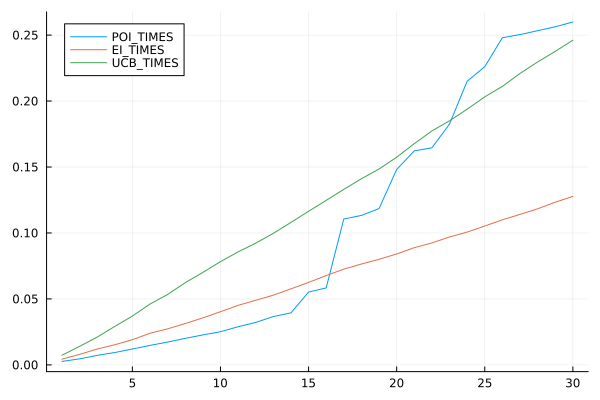

In [45]:
plot(1:BUDGET, poi_stats[1], label="POI_TIMES")
plot!(1:BUDGET, ei_stats[1], label="EI_TIMES")
plot!(1:BUDGET, ucb_stats[1], label="UCB_TIMES")